In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product

cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


Each pixel on the target tweezer array corresponds to: 5.0480769230769225 microns
Airy disk radius is: 20.015625000000004 microns
Tweezer spacing is: 30.288461538461533 microns


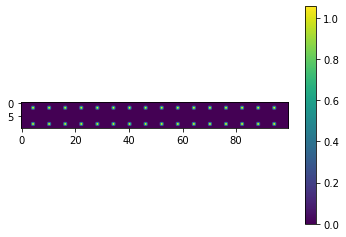

In [23]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff



sizefactor = 3
tweezerspacing = 6
numxtweezers = 20
numytweezers = 20
imgname = f"{numxtweezers}by{numytweezers}_{tweezerspacing}spacing_mag{sizefactor}" # DEFINE NAME FIRST
tweezerarray = createtweezers_grid(cp.zeros((numpixels*sizefactor,numpixels*sizefactor)), tweezerspacing, numxtweezers, numytweezers, 350)
# plt.imshow(zoomin(expand(tweezerarray,1)))


# For direct 250 mm lens imaging
pixelpitch = 8 * 10**(-6)# microns
focallength = 250 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

# For objectives imaging
# pixelpitch = (8 * 200/250 * 10**(-6))# microns
# focallength = 9.1 * 10**(-3) # mm
# wavelength = 630 * 10**(-9)

fourierplanesize = wavelength * focallength / pixelpitch / (numpixels * sizefactor)
print(f"Each pixel on the target tweezer array corresponds to: {fourierplanesize*10**6} microns")

airydiskradius = 1.22 * wavelength * focallength / (pixelpitch*1200)
print(f"Airy disk radius is: {airydiskradius * 10**6} microns")
print(f"Tweezer spacing is: {tweezerspacing * fourierplanesize * 10**6} microns")

# tweezerarray = cp.array(gaussian_filter(tweezerarray.get(), airydiskradius / fourierplanesize /(2 * np.sqrt(2 * np.log(2)))))
tweezerarray = cp.array(gaussian_filter(tweezerarray.get(), 0.2))
tweezerarray = tweezerarray / cp.max(tweezerarray)
weightedtweezerarray, diffractionefficiency= applydiffractionlimited(tweezerarray, fourierplanesize, pixelpitch, wavelength, focallength)
# plt.imshow(zoomin(tweezerarray).get())
plt.imshow(weightedtweezerarray.get()[1900:1910, 2300:2400])
plt.colorbar()


In [3]:
# Get the kvectors from the tweezer array
kvector_tweezers = makeinitialkvectors(tweezerarray)
harmonics = identifyharmonics(kvector_tweezers, 0)
harmonics_coordinates = frequenciestopixels_harmonicsonly(harmonics, tweezerarray)
# Calculate offsets
kvector_initoffsets = Off_Calc(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
randomguess = cp.random.rand(1300, 1300)

In [4]:
# Get initial phase guess
initialphaseguess = create_phasemap(kvector_tweezers, kvector_initoffsets, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)

In [48]:
# Derive necessary phase for tweezers   randomguess = cp.rand.random(cp.shape(numpixels, numpixels))
optimizedout  = derivephase(Pen_Lukin, weightedtweezerarray, initialphaseguess, 100,1)


In [5]:
# Derive necessary phase for tweezers - fixed phase method
optimizedout_fixedphase  = derivephase_fixed(Pen_Lukin, weightedtweezerarray, initialphaseguess, 150, 100,1)

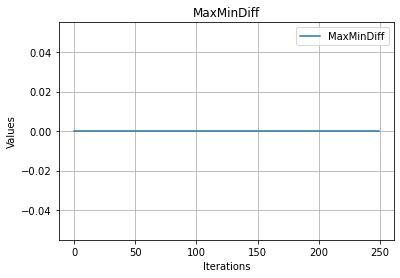

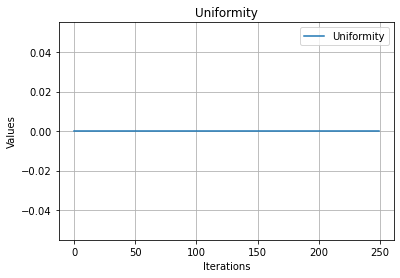

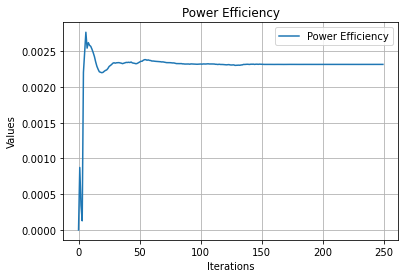

In [26]:
# errors = optimizedout.get_all_errors()
# labels = optimizedout.get_all_labels()
# errors_fixedphase = optimizedout_fixedphase.get_all_errors()
# labels_fixedphase = optimizedout_fixedphase.get_all_labels()

# errors_combined = errors.copy()
# for i in range(len(errors_combined)):
#     errors_combined[i] = np.append((errors[i].get()),(errors_fixedphase[i].get()))

# for i, label in enumerate(labels):
#     plt.figure()
#     plt.loglog(errors_combined[i], label=str(cp.asnumpy(label))+" calcoff")
#     plt.title(label)
#     plt.legend()
#     plt.xlabel('Iterations')
#     plt.ylabel('Values')
#     plt.grid(True)
#     plt.show()


errors_thing = optimizedout_fixedphase.get_all_errors()
labels_thing = optimizedout_fixedphase.get_all_labels()

for i, label in enumerate(labels_thing):
    plt.figure()
    plt.plot(errors_thing[i].get(), label=label)
    # plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

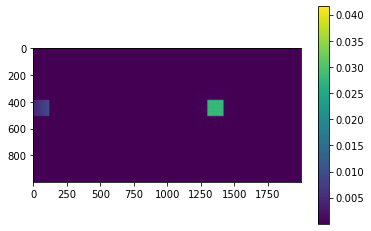

In [27]:
plt.imshow(gaussian_filter(optimizedout_fixedphase.get_stdint().get()[1500:2500, 1000:3000],2))
plt.colorbar()

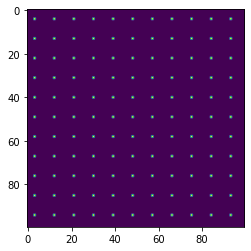

In [66]:
plt.imshow(tweezerarray.get()[1850:1950, 2400:2500])

In [ ]:
optimizedout_randguess  = derivephase(Pen_DeltaSqrt, tweezerarray, cp.random.rand(numpixels, numpixels), 100,1)

In [ ]:
kvector_initoffsets_none = Off_None(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
initialphaseguess_nooffsets = create_phasemap(kvector_tweezers, kvector_initoffsets_none, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)
optimizedout_nooffsets  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess_nooffsets, 1000,1)

In [28]:
optimizedout = optimizedout_fixedphase
# Convert to image files, and store!
import os
save_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS-Summer2024\storage'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
phaseimg_path = os.path.join(save_dir, f"{imgname}_phase.bmp")
virtualintimg_path = os.path.join(save_dir, f"{imgname}_virtualint.jpg")
intimg_path = os.path.join(save_dir, f"{imgname}_int.jpg")


saver = np.zeros((1200,1920))
saver[0:1200,int(1920/2-sizepix/2):int(1920/2+sizepix/2)] = (optimizedout.get_slmphase().get()[50:1250,:] / np.max(optimizedout.get_slmphase().get()[50:1250,:])*255)
phaseimg = (Image.fromarray(saver).convert('RGB'))
virtualintimg = (Image.fromarray((optimizedout.get_stdint().get() / np.max(optimizedout.get_stdint().get()) * 255).astype(np.uint8)).convert('RGB'))
intimg =(tweezerarray.get() / np.max(tweezerarray.get()) * 255).astype(np.uint8)
phaseimg.save(phaseimg_path)
virtualintimg.save(virtualintimg_path)
cv2.imwrite(intimg_path, intimg)

#####################################################3

True

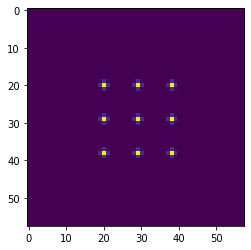

In [ ]:
plt.imshow(zoomin(remove0thorder(optimizedout.get_stdint()),3000).get())

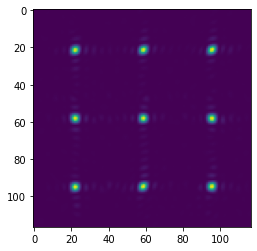

In [ ]:
opt_tweezers_precise = remove0thorder(simulatefourier(zeropad(optimizedout.get_slmphase(), 4000), magnification=1))
plt.imshow(zoomin((opt_tweezers_precise),100).get())

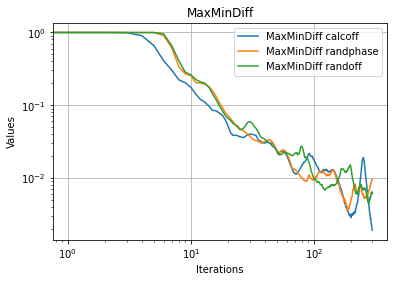

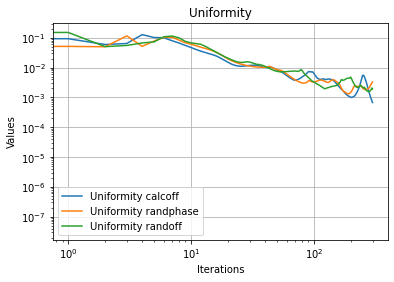

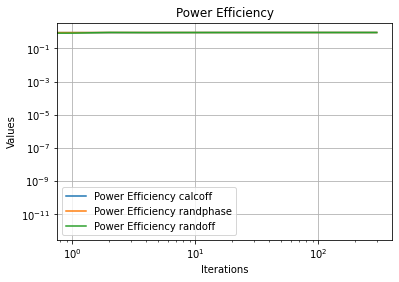

In [ ]:
errors = optimizedout.get_all_errors()
labels = optimizedout.get_all_labels()
errors_rand = optimizedout_randguess.get_all_errors()
labels_rand = optimizedout_randguess.get_all_labels()
errors_nooff = optimizedout_nooffsets.get_all_errors()
labels_nooff = optimizedout_nooffsets.get_all_labels()
for i, label in enumerate(labels):
    plt.figure()
    plt.loglog(errors[i].get(), label=str(cp.asnumpy(label))+" calcoff")
    plt.loglog(errors_rand[i].get(), label=str(cp.asnumpy(label))+" randphase")
    plt.loglog(errors_nooff[i].get(), label=str(cp.asnumpy(label))+" randoff")
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()
